In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import ast, math

In [2]:
# Load the data
eur_regression_df = pd.read_csv('W10_eur_regression_results.csv')
usd_regression_df = pd.read_csv('W10_usd_regression_results.csv')

# Plot with both USD and EUR feature importances side by side for each expiry x tenor combo

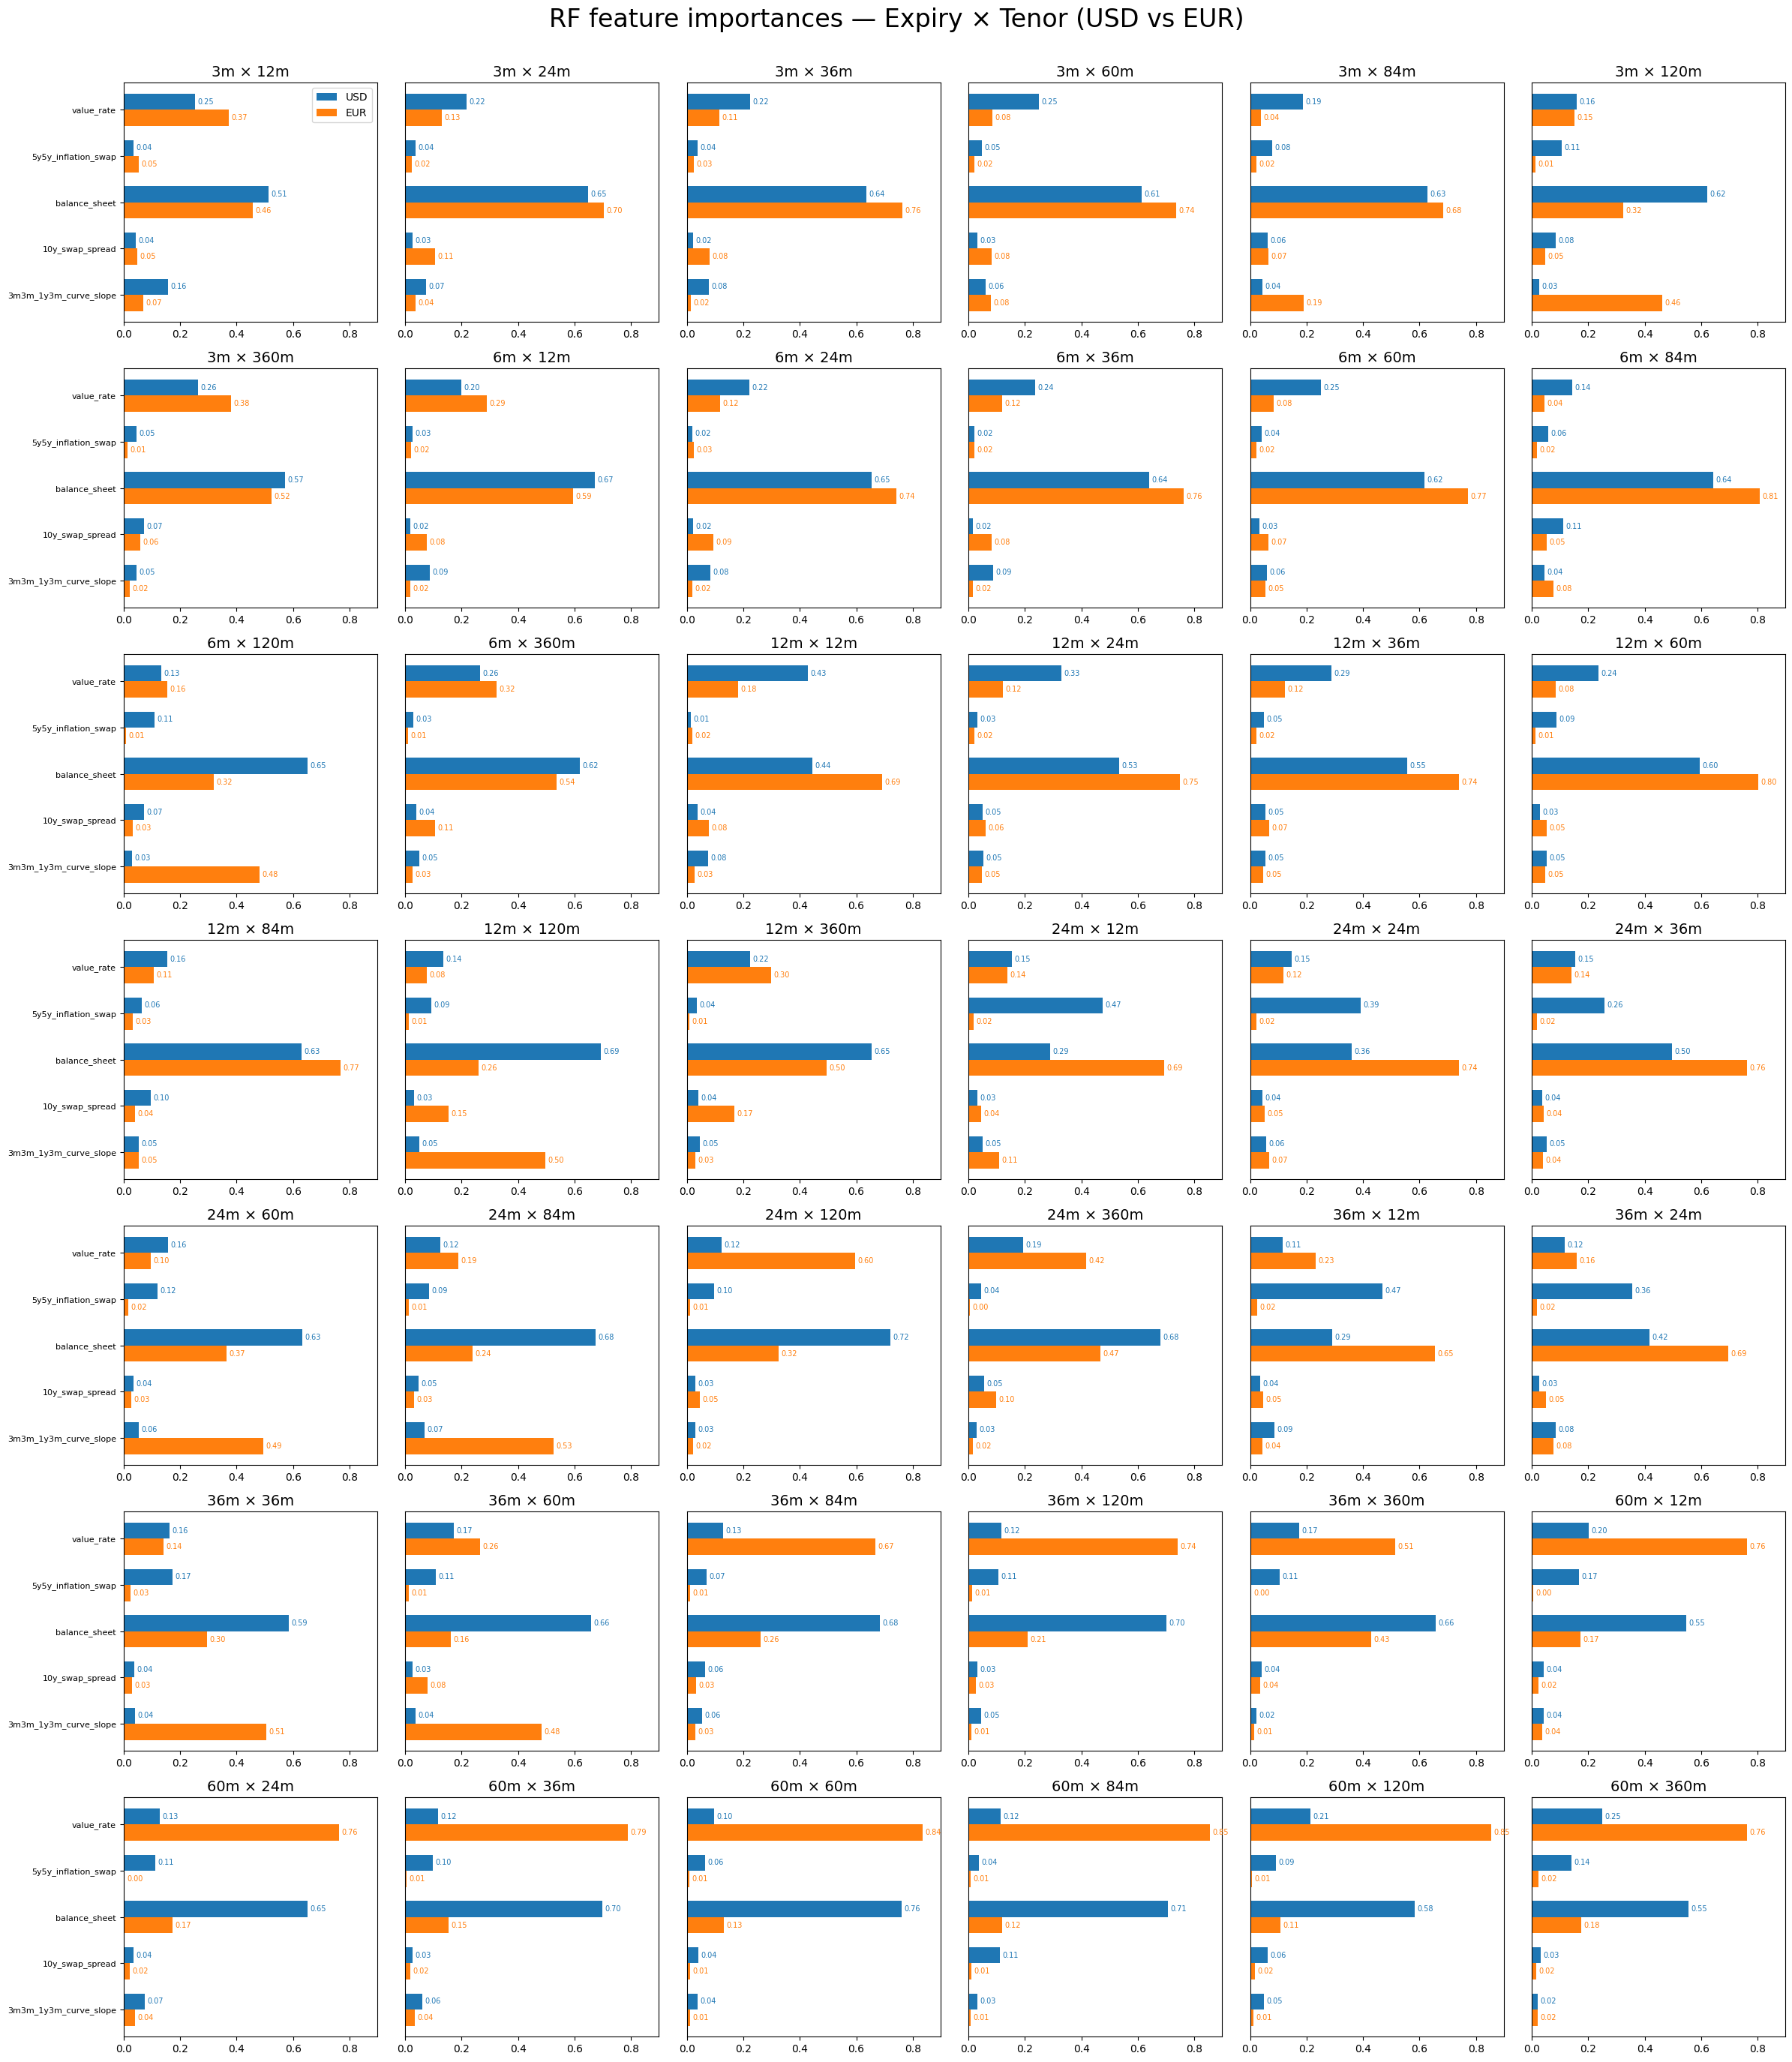

Saved: figure13.png


In [ ]:

df_usd =  usd_regression_df.copy()
df_eur = eur_regression_df.copy()

macro_features = ['value_rate','5y5y_inflation_swap','balance_sheet','10y_swap_spread','3m3m_1y3m_curve_slope']

def ensure_rf_imp_cols(df):
    df = df.copy().reset_index(drop=True)
    # if rf_imp_<f> present skip; otherwise try to parse rf_importances col
    for f in macro_features:
        col = f'rf_imp_{f}'
        if col not in df.columns:
            if 'rf_importances' in df.columns:
                def parse_imp(x, feat=f):
                    if pd.isna(x):
                        return np.nan
                    try:
                        d = x if not isinstance(x, str) else ast.literal_eval(x)
                    except Exception:
                        try:
                            d = eval(x) if isinstance(x, str) else x
                        except Exception:
                            return np.nan
                    if isinstance(d, dict):
                        return float(d.get(feat, 0.0))
                    if isinstance(d, (list, tuple, np.ndarray)):
                        try:
                            idx = macro_features.index(feat)
                            return float(d[idx])
                        except Exception:
                            return np.nan
                    return np.nan
                df[col] = df['rf_importances'].apply(parse_imp)
            else:
                df[col] = np.nan
    return df

df_usd = ensure_rf_imp_cols(df_usd)
df_eur = ensure_rf_imp_cols(df_eur)

# union of combos present in either dataset
combos_usd = set(tuple(x) for x in df_usd[['start_months','tenor_months']].dropna().drop_duplicates().values.tolist())
combos_eur = set(tuple(x) for x in df_eur[['start_months','tenor_months']].dropna().drop_duplicates().values.tolist())
combos = sorted(list(combos_usd | combos_eur), key=lambda t: (int(t[0]), int(t[1])))

# prepare rf columns in order
rf_cols = [f'rf_imp_{f}' for f in macro_features]

# filter combos where at least one dataset has non-NaN importances
valid = []
for s,t in combos:
    row_usd = df_usd.query("start_months==@s and tenor_months==@t")
    row_eur = df_eur.query("start_months==@s and tenor_months==@t")
    has_usd = (len(row_usd)>0) and row_usd[rf_cols].notna().any(axis=None)
    has_eur = (len(row_eur)>0) and row_eur[rf_cols].notna().any(axis=None)
    if has_usd or has_eur:
        valid.append((s,t))
combos = valid
n = len(combos)
if n == 0:
    print("No RF importances available (USD or EUR).")
else:
    ncols = 6
    nrows = math.ceil(n / ncols)
    figsize = (ncols * 4, max(4, nrows * 4))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes_flat = axes.flatten()

    # global x limit across both currencies
    global_max = 0.0
    for df in (df_usd, df_eur):
        if not df.empty:
            m = df[rf_cols].max().max()
            if pd.notna(m) and m > global_max:
                global_max = float(m)
    xlim_max = float(global_max * 1.05) if global_max > 0 else 1.0

    bar_h = 0.35  # half-height for the two offset bars
    for i, (s,t) in enumerate(combos):
        ax = axes_flat[i]
        # fetch first matching row (there should be only one combo row per df_all)
        row_usd = df_usd.query("start_months==@s and tenor_months==@t")
        row_eur = df_eur.query("start_months==@s and tenor_months==@t")

        usd_vals = [float(row_usd[c].iloc[0]) if (len(row_usd)>0 and pd.notna(row_usd[c].iloc[0])) else 0.0 for c in rf_cols]
        eur_vals = [float(row_eur[c].iloc[0]) if (len(row_eur)>0 and pd.notna(row_eur[c].iloc[0])) else 0.0 for c in rf_cols]

        y = np.arange(len(macro_features))

        # USD (blue) slightly above center, EUR (orange) slightly below
        ax.barh(y - bar_h/2, usd_vals, height=bar_h, color='C0', label='USD' if i==0 else "")
        ax.barh(y + bar_h/2, eur_vals, height=bar_h, color='C1', label='EUR' if i==0 else "")

        # y-ticks only labeled on leftmost column
        row_idx, col_idx = divmod(i, ncols)
        ax.set_yticks(y)
        if col_idx == 0:
            ax.set_yticklabels(macro_features, fontsize=8)
        else:
            ax.set_yticklabels([])
            ax.tick_params(axis='y', which='both', length=0)

        ax.set_xlim(0, xlim_max)
        ax.invert_yaxis()
        title = f"{int(s)}m × {int(t)}m"
        ax.set_title(title, fontsize=14)

        # annotate values for both bars
        for yi, (u,e) in enumerate(zip(usd_vals, eur_vals)):
            if u > 0:
                ax.text(u + xlim_max*0.01, yi - bar_h/2, f"{u:.2f}", va='center', fontsize=7, color='C0')
            if e > 0:
                ax.text(e + xlim_max*0.01, yi + bar_h/2, f"{e:.2f}", va='center', fontsize=7, color='C1')

    # turn off leftover axes
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    # legend on top-left subplot
    axes_flat[0].legend(loc='upper right', fontsize=10)
    fig.suptitle('RF feature importances — Expiry × Tenor (USD vs EUR)', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.975])
    plt.show()

    out_path = 'figure13.png'
    fig.savefig(out_path, bbox_inches='tight', dpi=300)
    print(f"Saved: {out_path}")
# ...existing code...

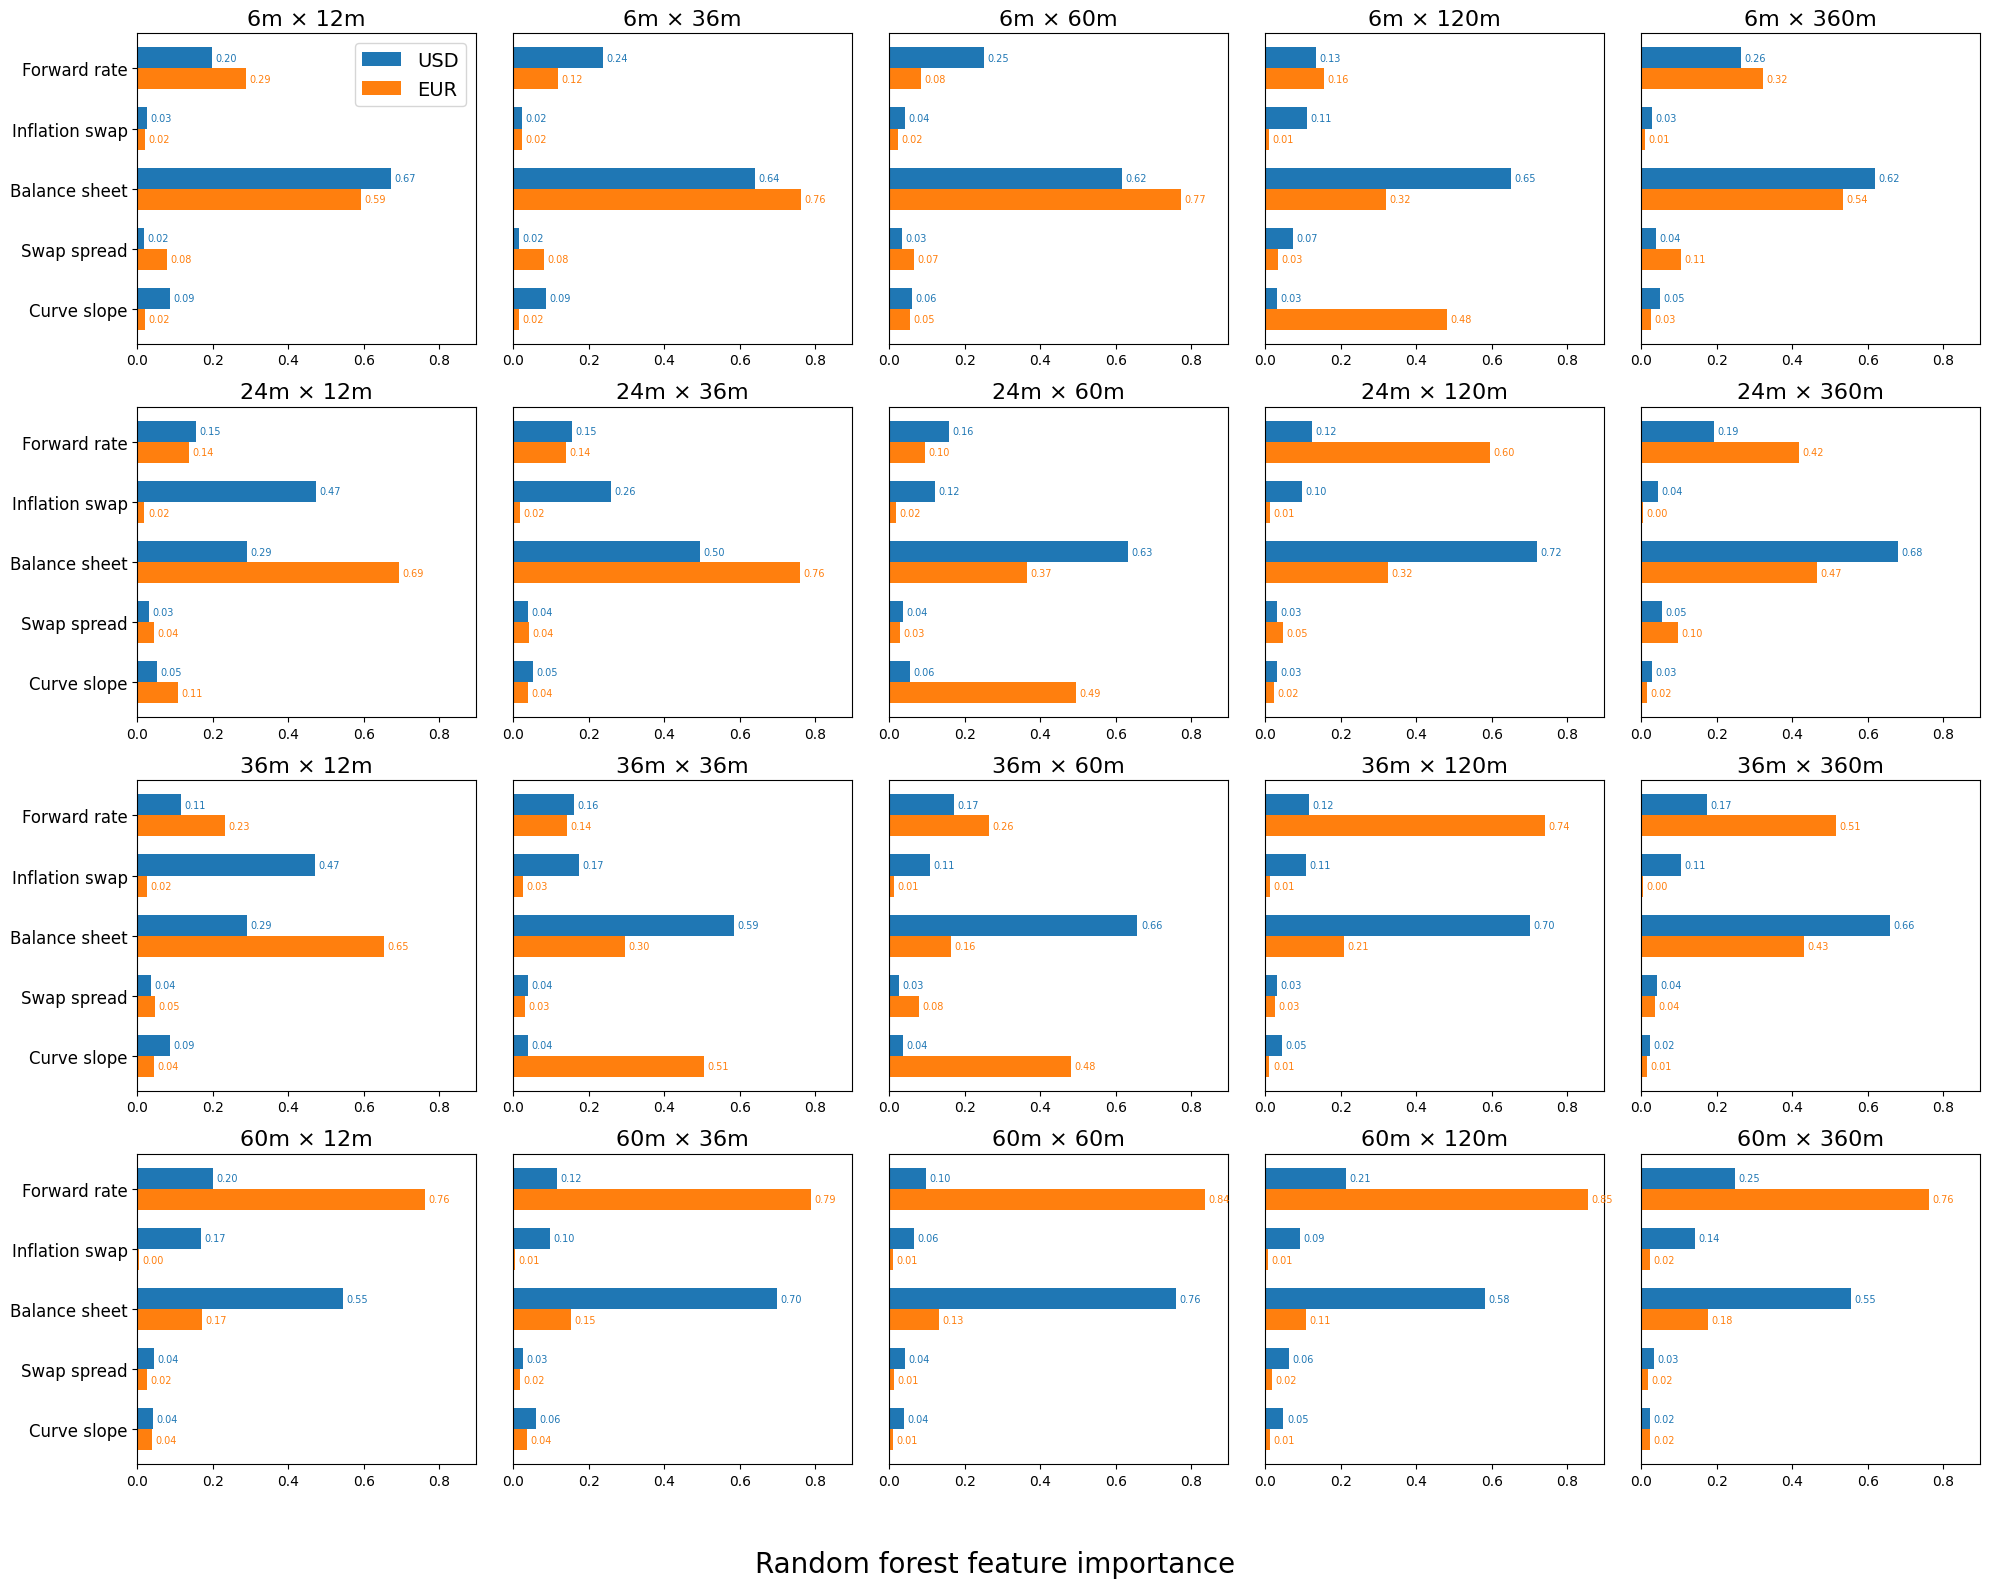

Saved: figure14.png


In [ ]:
# Cleaner version for the thesis

label_map = {
    'value_rate': 'Forward rate',
    '5y5y_inflation_swap': 'Inflation swap',
    'balance_sheet': 'Balance sheet',
    '10y_swap_spread': 'Swap spread',
    '3m3m_1y3m_curve_slope': 'Curve slope'
}

import ast, math

# load if not already in workspace
df_usd = usd_regression_df.copy()
df_eur = eur_regression_df.copy()

macro_features = ['value_rate','5y5y_inflation_swap','balance_sheet','10y_swap_spread','3m3m_1y3m_curve_slope']

def ensure_rf_imp_cols(df):
    df = df.copy().reset_index(drop=True)
    for f in macro_features:
        col = f'rf_imp_{f}'
        if col not in df.columns:
            if 'rf_importances' in df.columns:
                def parse_imp(x, feat=f):
                    if pd.isna(x):
                        return np.nan
                    try:
                        d = x if not isinstance(x, str) else ast.literal_eval(x)
                    except Exception:
                        try:
                            d = eval(x) if isinstance(x, str) else x
                        except Exception:
                            return np.nan
                    if isinstance(d, dict):
                        return float(d.get(feat, 0.0))
                    if isinstance(d, (list, tuple, np.ndarray)):
                        try:
                            idx = macro_features.index(feat)
                            return float(d[idx])
                        except Exception:
                            return np.nan
                    return np.nan
                df[col] = df['rf_importances'].apply(parse_imp)
            else:
                df[col] = np.nan
    return df

df_usd = ensure_rf_imp_cols(df_usd)
df_eur = ensure_rf_imp_cols(df_eur)

# union of combos present in either dataset
combos_usd = set(tuple(x) for x in df_usd[['start_months','tenor_months']].dropna().drop_duplicates().values.tolist())
combos_eur = set(tuple(x) for x in df_eur[['start_months','tenor_months']].dropna().drop_duplicates().values.tolist())
combos_all = sorted(list(combos_usd | combos_eur), key=lambda t: (int(t[0]), int(t[1])))

# prepare rf columns in order
rf_cols = [f'rf_imp_{f}' for f in macro_features]

# filter combos where at least one dataset has non-NaN importances
valid = []
for s,t in combos_all:
    row_usd = df_usd.query("start_months==@s and tenor_months==@t")
    row_eur = df_eur.query("start_months==@s and tenor_months==@t")
    has_usd = (len(row_usd) > 0) and row_usd[rf_cols].notna().any(axis=None)
    has_eur = (len(row_eur) > 0) and row_eur[rf_cols].notna().any(axis=None)
    if has_usd or has_eur:
        valid.append((int(s), int(t)))

# === Format changes to match the new layout ===
# Remove 3m & 12m expiries and 24m tenors; keep up to 4x6 = 24 panels
combos = [(s, t) for (s, t) in valid if s not in (3, 12) and t not in (24, 84)]
combos = sorted(combos, key=lambda t: (t[0], t[1]))[:24]

if len(combos) == 0:
    print("No RF importances available (USD or EUR) after filtering.")
else:
    # Fixed 4 × 6 grid
    ncols, nrows = 5, 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), squeeze=False)
    axes_flat = axes.flatten()

    # global x limit across both currencies
    global_max = 0.0
    for df in (df_usd, df_eur):
        if not df.empty:
            m = df[rf_cols].max().max()
            if pd.notna(m) and m > global_max:
                global_max = float(m)
    xlim_max = float(global_max * 1.05) if global_max > 0 else 1.0

    bar_h = 0.35  # half-height for the two offset bars
    for i, (s, t) in enumerate(combos):
        ax = axes_flat[i]

        row_usd = df_usd.query("start_months==@s and tenor_months==@t")
        row_eur = df_eur.query("start_months==@s and tenor_months==@t")

        usd_vals = [float(row_usd[c].iloc[0]) if (len(row_usd)>0 and pd.notna(row_usd[c].iloc[0])) else 0.0 for c in rf_cols]
        eur_vals = [float(row_eur[c].iloc[0]) if (len(row_eur)>0 and pd.notna(row_eur[c].iloc[0])) else 0.0 for c in rf_cols]

        y = np.arange(len(macro_features))

        # USD (C0) slightly above center, EUR (C1) slightly below
        ax.barh(y - bar_h/2, usd_vals, height=bar_h, color='C0', label='USD' if i == 0 else "")
        ax.barh(y + bar_h/2, eur_vals, height=bar_h, color='C1', label='EUR' if i == 0 else "")

        # y-ticks only labeled on leftmost column; use pretty labels
        _, col_idx = divmod(i, ncols)
        ax.set_yticks(y)
        if col_idx == 0:
            ax.set_yticklabels([label_map[f] for f in macro_features], fontsize=12)
        else:
            ax.set_yticklabels([])
            ax.tick_params(axis='y', which='both', length=0)

        ax.set_xlim(0, xlim_max)
        ax.invert_yaxis()
        ax.set_title(f"{s}m × {t}m", fontsize=16)

        # annotate values for both bars
        for yi, (u, e) in enumerate(zip(usd_vals, eur_vals)):
            if u > 0:
                ax.text(u + xlim_max*0.01, yi - bar_h/2, f"{u:.2f}", va='center', fontsize=7, color='C0')
            if e > 0:
                ax.text(e + xlim_max*0.01, yi + bar_h/2, f"{e:.2f}", va='center', fontsize=7, color='C1')

        # no per-axes x-labels

    # turn off leftover axes in the fixed grid
    for j in range(len(combos), len(axes_flat)):
        axes_flat[j].axis('off')

    # legend on top-right of the first active subplot
    axes_flat[0].legend(loc='upper right', fontsize=14)

    # === No overall title; single shared x-axis label ===
    fig.supxlabel('Random forest feature importance', fontsize=20)

    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()

    out_path = 'figure14.png'
    fig.savefig(out_path, bbox_inches='tight', dpi=300)
    print(f"Saved: {out_path}")
# ...existing code...
